
# The Julia-is-Fast Benchmark Fun: `sum`

 (This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

In this notebook we are going to compare performance of a very simple function across several different languages: The `sum`. This function computes
 
$$\text{sum}(a) = \sum_{i=1}^n a_i$$

where $n$ is the length of `a`.
Let's get a vector of numbers:

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.1663319579196314 
 0.30895312060879365
 0.6179474041044644 
 0.06127644374834973
 0.2573021832089899 
 0.16796863745240764
 0.27852662730874767
 0.5086510453252497 
 0.1560114763009781 
 0.7288501465239252 
 0.11324653454998068
 0.12629501636416296
 0.9000757666639296 
 ⋮                  
 0.7236680378178086 
 0.8672746082443499 
 0.6332323213343003 
 0.4469263836490769 
 0.6862137821151018 
 0.9506520059092591 
 0.17982818693745917
 0.06950168957092684
 0.7418679573560714 
 0.6435725623459287 
 0.9592755512624958 
 0.9511577329348149 

We would expect to see 0.5*10^7, since each element has an expected value of 0.5.

## Benchmarks in different languages

We will use BenchmarkTools.jl for this exercise. This is because the standard `@time` macro suffers from sample bias:

In [2]:
@time sum(a)

@time sum(a)

@time sum(a)

  0.045626 seconds (94.66 k allocations: 4.730 MiB)
  0.004711 seconds (5 allocations: 176 bytes)
  0.004619 seconds (5 allocations: 176 bytes)


5.000250466313629e6

In [3]:
using BenchmarkTools

## `C` is what you have to beat

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

One can compile C code in Julia. Note that the `"""` wrap a multi-line string.

In [4]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):
using Libdl

open(`gcc  -fPIC -O3 -ffast-math -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum(a)

c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

c_bench = @benchmark c_sum($a)

println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

C: Fastest time was 4.414939 msec


Dict{Any,Any} with 1 entry:
  "C" => 4.41494

We can see above that the BenchmarkTools library takes many sample runs to account for machine noise in the benchmark. We can look at the distribution of times:

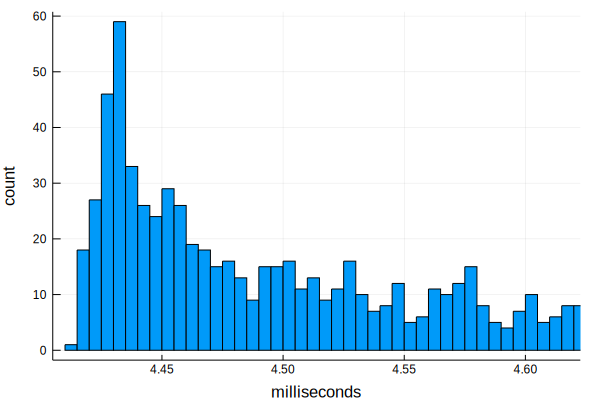

In [5]:
using Plots

t = c_bench.times / 1e6 # times in milliseconds
using Statistics
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

## Next: python's built-in `sum`

In [6]:
using PyCall

# Call a low-level PyCall function to get a Python list, because
# by default PyCall will convert to a NumPy array instead (we benchmark NumPy below):

apy_list = PyCall.array2py(a, 1, 1)

# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

pysum(a)

pysum(a) ≈ sum(a)

py_list_bench = @benchmark $pysum($apy_list)

d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d


Dict{Any,Any} with 2 entries:
  "C"               => 4.41494
  "Python built-in" => 54.7549

## Next: python's numpy `sum`

Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be used within Julia as follows:


In [7]:
using Conda 

numpy_sum = pyimport("numpy")["sum"]
apy_numpy = PyObject(a) # converts to a numpy array by default

py_numpy_bench = @benchmark $numpy_sum($apy_numpy)

numpy_sum(apy_list) # python thing

numpy_sum(apy_list) ≈ sum(a)

d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 4.41494
  "Python numpy"    => 4.6328
  "Python built-in" => 54.7549

## Next: python hand-written
 
We could try and see how our hand-written implementation performs:

In [8]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

py_hand = @benchmark $sum_py($apy_list)

sum_py(apy_list)

sum_py(apy_list) ≈ sum(a)

d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"                   => 4.41494
  "Python numpy"        => 4.6328
  "Python hand-written" => 284.278
  "Python built-in"     => 54.7549

## julia built-in

`julia`s library is written entirely in julia! No `C` at all! you can easily look at the code by typing

In [9]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

In [10]:
j_bench = @benchmark sum($a)

d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 4.41494
  "Python numpy"        => 4.6328
  "Python hand-written" => 284.278
  "Python built-in"     => 54.7549
  "Julia built-in"      => 4.48438

## julia hand-written

In [11]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    for a in A
        s += a
    end
    s
end

j_bench_hand = @benchmark mysum($a)

d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 4.41494
  "Python numpy"        => 4.6328
  "Julia hand-written"  => 9.74541
  "Python hand-written" => 284.278
  "Python built-in"     => 54.7549
  "Julia built-in"      => 4.48438

## `R` built-in

In [12]:
using RCall

r_bench = @benchmark R"sum($a)"
d["R built-in"] = minimum(r_bench.times) / 1e6

┌ Info: Recompiling stale cache file /Users/florian.oswald/.julia/compiled/v1.0/RCall/8GFyb.ji for RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1190


48.683041

## Summary

In [13]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value,digits= 2), 10, "."))
end

C.........................4.41
Julia built-in............4.48
Python numpy..............4.63
Julia hand-written........9.75
R built-in...............48.68
Python built-in..........54.75
Python hand-written.....284.28


### Take aways (on my computer!):

1. `C` is fastest
1. built-in julia checks out very close to `C`, and ex-equo with the numpy
1. Hand written julia gets compiled to very efficient machine code in this example.
1. Python and R built-in sums are roughly 10 times slower than `C`, `julia` and `numpy`
1. Hand writing python code without any optimizations performs poorly in this instance.